# Testing python interface for Thorlabs APT
awojdyla@lbl.gov, Dec 2025

In [230]:
import pylablib

In [ ]:
# stage = Thorlabs.KinesisMotor("27000001")  # connect to the stage
# stage.home()  # home the stage
# stage.wait_for_home()  # wait until homing is done
# stage.move_by(1000)  # move by 1000 steps
# stage.wait_move()  # wait until moving is done
# stage.jog("+")  # initiate jog (continuous move) in the positive direction
# time.sleep(1.)  # wait for 1 second
# stage.stop()  # stop the motion
# stage.close()

In [231]:
from pylablib.devices import Thorlabs

# List available APT devices
devices = Thorlabs.list_kinesis_devices()
print("Available devices:", devices)



Available devices: [('83812453', 'APT DC Motor Controller'), ('83829778', 'APT DC Motor Controller'), ('83813170', 'APT DC Motor Controller'), ('83815134', 'APT DC Motor Controller')]


In [232]:
# Connect to the motor (replace with your device serial number)
motor_x = Thorlabs.KinesisMotor('83829778')
motor_y = Thorlabs.KinesisMotor('83815134')
motor_z = Thorlabs.KinesisMotor('83812453')

In [243]:
motor_x.move_by(-5000)

In [242]:
motor_y.move_by(-10000)

In [ ]:
motor_z.move_by(-1000000)

## connect to camera

In [20]:
from pypylon import pylon

tl_factory = pylon.TlFactory.GetInstance()

# Create a device info object and set the IP address
device_info = pylon.DeviceInfo()
device_info.SetDeviceClass("BaslerGigE")  # Ensure we target GigE cameras
device_info.SetIpAddress("192.168.10.212")

# Try to create the camera object
camera = pylon.InstantCamera(tl_factory.CreateDevice(device_info))



In [212]:
camera.Open()
print(f"Connected to camera: {camera.GetDeviceInfo().GetModelName()}")

Connected to camera: a2A1920-51gcBAS


In [244]:
# Acquire one image from the camera
# Set exposure time to minimum (19 microseconds)
camera.ExposureTime.SetValue(19)
print(f"Exposure time set to: {camera.ExposureTime.GetValue()} µs")
camera.StartGrabbingMax(1)
grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

if grab_result.GrabSucceeded():
    image = grab_result.Array
    print(f"Image acquired successfully. Shape: {image.shape}")
else:
    print("Image grab failed")

grab_result.Release()
camera.StopGrabbing()

Exposure time set to: 19.0 µs
Image acquired successfully. Shape: (1200, 1920)


Camera model: a2A1920-51gcBAS
Using pixel size: 3.450 µm (X/Y assumed equal)


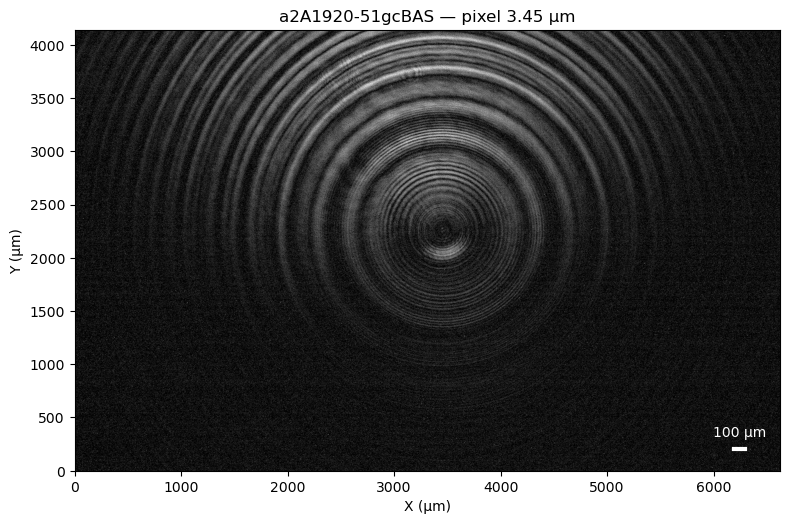

In [245]:
# Determine pixel size automatically for known cameras (Basler a2A1920-51gc with Sony IMX392)
# and fall back to probing the camera node map or asking the user.
from matplotlib import pyplot as plt
import numpy as np

def _try_get_node_value(nodemap, candidates):
    for name in candidates:
        try:
            node = nodemap.GetNode(name)
            if node is not None:
                try:
                    val = node.GetValue()
                except Exception:
                    # some nodes may need ToString()
                    try:
                        val = float(node.ToString())
                    except Exception:
                        val = None
                if val is not None:
                    return float(val)
        except Exception:
            continue
    return None

# Known camera -> pixel size (µm)
model = camera.GetDeviceInfo().GetModelName()
pixel_size_um = None
if any(k in model for k in ("a2A1920-51gc", "a2A1920-51", "IMX392")):
    # Sony IMX392 pixel pitch
    pixel_size_um = 3.45

if pixel_size_um is None:
    try:
        nodemap = camera.GetNodeMap()
        pixel_candidates = ["PixelSize", "PixelSizeX", "PixelSizeUm", "PixelPitch"]
        pixel_size_um = _try_get_node_value(nodemap, pixel_candidates)
        # try sensor width -> compute pixel pitch
        if pixel_size_um is None:
            sensor_candidates = ["SensorWidth", "SensorWidth_mm", "SensorWidth_um"]
            sensor_width = _try_get_node_value(nodemap, sensor_candidates)
            if sensor_width is not None:
                # guess units: if < 10 assume mm else µm
                if sensor_width < 10:
                    sensor_width_mm = sensor_width
                else:
                    sensor_width_mm = sensor_width / 1000.0
                pixel_size_um = (sensor_width_mm * 1000.0) / image.shape[1]
    except Exception:
        pixel_size_um = None

if pixel_size_um is None:
    # prompt the user as last resort
    try:
        pixel_size_um = float(input("Pixel size (µm) not found. Enter pixel size in micrometers: ").strip())
    except Exception:
        raise RuntimeError("Pixel size not available from camera; please provide it manually.")

print(f"Camera model: {model}")
print(f"Using pixel size: {pixel_size_um:.3f} µm (X/Y assumed equal)")

# store for downstream cells
camera_pixel_size_um = pixel_size_um

# Plot image with physical axes and optional scale bar
from matplotlib import pyplot as plt
import numpy as np

def add_scalebar(ax, length_um, pixel_size_um, location='lower right', color='white', fontsize=10, pad=0.1):
    """Add a simple scalebar in axis coordinates."""
    # convert length in µm to axis data units
    length_data = length_um
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    # place in axis coords
    if location == 'lower right':
        x = xlim[1] - (xlim[1] - xlim[0]) * 0.05 - length_data
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
    elif location == 'lower left':
        x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
    else:
        x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
        y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
    ax.plot([x, x + length_data], [y, y], color=color, linewidth=3)
    ax.text(x + length_data / 2, y + (ylim[1] - ylim[0]) * 0.02, f"{length_um:g} µm",
            color=color, ha='center', va='bottom', fontsize=fontsize)

# choose unit: 'um' or 'mm'
unit = 'um'

h, w = image.shape[:2]
pixel_size_um = camera_pixel_size_um
if unit == 'um':
    x_max = w * pixel_size_um
    y_max = h * pixel_size_um
    xlabel = 'X (µm)'
    ylabel = 'Y (µm)'
elif unit == 'mm':
    x_max = w * pixel_size_um / 1000.0
    y_max = h * pixel_size_um / 1000.0
    xlabel = 'X (mm)'
    ylabel = 'Y (mm)'
else:
    raise ValueError("unit must be 'um' or 'mm'")

extent = (0, x_max, 0, y_max)  # left, right, bottom, top in chosen unit
plt.figure(figsize=(8,6))
ax = plt.gca()
if image.ndim == 2:
    plt.imshow(image, cmap='gray', extent=extent, origin='lower')
else:
    plt.imshow(image, extent=extent, origin='lower')
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(f"{model} — pixel {pixel_size_um:.2f} µm")
plt.tight_layout()

# add a 100 µm scalebar by default (adjust as needed)
try:
    add_scalebar(ax, length_um=100, pixel_size_um=pixel_size_um, location='lower right', color='white')
except Exception:
    pass

plt.show()

In [255]:
def acquire_and_plot_image(camera, exposure_time_us=19, unit='um', scalebar_length_um=100, figsize=(6,4), title=None):
    """
    Acquire one image from the camera and plot it with physical axes.
    
    Parameters:
    -----------
    camera : pypylon.pylon.InstantCamera
        The camera instance to acquire from
    exposure_time_us : float, optional
        Exposure time in microseconds (default: 19)
    unit : str, optional
        'um' or 'mm' for axis units (default: 'um')
    scalebar_length_um : float, optional
        Length of scalebar in micrometers (default: 100)
    figsize : tuple, optional
        Figure size (default: (6,4))
    title : str, optional
        Custom title for the plot. If None, uses default format (default: None)
    
    Returns:
    --------
    image : numpy.ndarray
        The acquired image
    pixel_size_um : float
        The pixel size in micrometers
    """
    import numpy as np
    from matplotlib import pyplot as plt
    
    # Set exposure and acquire
    camera.ExposureTime.SetValue(exposure_time_us)
    # print(f"Exposure time set to: {camera.ExposureTime.GetValue()} µs")
    camera.StartGrabbingMax(1)
    grab_result = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    
    if grab_result.GrabSucceeded():
        image = grab_result.Array
        # print(f"Image acquired successfully. Shape: {image.shape}")
    else:
        print("Image grab failed")
        grab_result.Release()
        camera.StopGrabbing()
        return None, None
    
    grab_result.Release()
    camera.StopGrabbing()
    
    # Determine pixel size
    def _try_get_node_value(nodemap, candidates):
        for name in candidates:
            try:
                node = nodemap.GetNode(name)
                if node is not None:
                    try:
                        val = node.GetValue()
                    except Exception:
                        try:
                            val = float(node.ToString())
                        except Exception:
                            val = None
                    if val is not None:
                        return float(val)
            except Exception:
                continue
        return None
    
    model = camera.GetDeviceInfo().GetModelName()
    pixel_size_um = None
    
    if any(k in model for k in ("a2A1920-51gc", "a2A1920-51", "IMX392")):
        pixel_size_um = 3.45
    
    if pixel_size_um is None:
        try:
            nodemap = camera.GetNodeMap()
            pixel_size_um = _try_get_node_value(nodemap, ["PixelSize", "PixelSizeX", "PixelSizeUm", "PixelPitch"])
            if pixel_size_um is None:
                sensor_width = _try_get_node_value(nodemap, ["SensorWidth", "SensorWidth_mm", "SensorWidth_um"])
                if sensor_width is not None:
                    sensor_width_mm = sensor_width if sensor_width < 10 else sensor_width / 1000.0
                    pixel_size_um = (sensor_width_mm * 1000.0) / image.shape[1]
        except Exception:
            pass
    
    if pixel_size_um is None:
        try:
            pixel_size_um = float(input("Pixel size (µm) not found. Enter pixel size in micrometers: ").strip())
        except Exception:
            raise RuntimeError("Pixel size not available from camera; please provide it manually.")
    
    # print(f"Camera model: {model}")
    # print(f"Using pixel size: {pixel_size_um:.3f} µm (X/Y assumed equal)")
    
    # Plot with physical axes
    def add_scalebar(ax, length_um, pixel_size_um, location='lower right', color='white', fontsize=10):
        length_data = length_um
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if location == 'lower right':
            x = xlim[1] - (xlim[1] - xlim[0]) * 0.05 - length_data
            y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
        else:
            x = xlim[0] + (xlim[1] - xlim[0]) * 0.05
            y = ylim[0] + (ylim[1] - ylim[0]) * 0.05
        ax.plot([x, x + length_data], [y, y], color=color, linewidth=3)
        ax.text(x + length_data / 2, y + (ylim[1] - ylim[0]) * 0.02, f"{length_um:g} µm",
                color=color, ha='center', va='bottom', fontsize=fontsize)
    
    h, w = image.shape[:2]
    if unit == 'um':
        x_max = w * pixel_size_um
        y_max = h * pixel_size_um
        xlabel, ylabel = 'X (µm)', 'Y (µm)'
    elif unit == 'mm':
        x_max = w * pixel_size_um / 1000.0
        y_max = h * pixel_size_um / 1000.0
        xlabel, ylabel = 'X (mm)', 'Y (mm)'
    else:
        raise ValueError("unit must be 'um' or 'mm'")
    
    extent = (0, x_max, 0, y_max)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    plt.imshow(image, cmap='gray' if image.ndim == 2 else None, extent=extent, origin='lower')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Use custom title if provided, otherwise use default format
    if title is None:
        plt.title(f"{model} — pixel {pixel_size_um:.2f} µm")
    else:
        plt.title(title)
    
    plt.tight_layout()
    
    try:
        add_scalebar(ax, scalebar_length_um, pixel_size_um, color='white')
    except Exception:
        pass
    
    plt.show()
    
    return image, pixel_size_um


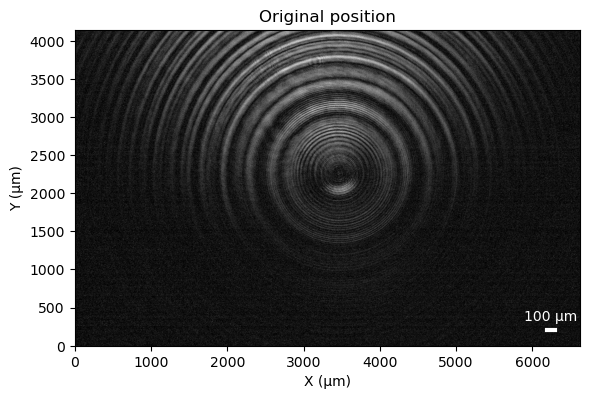

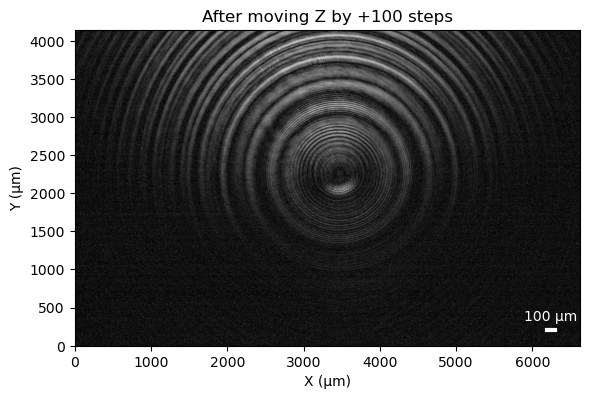

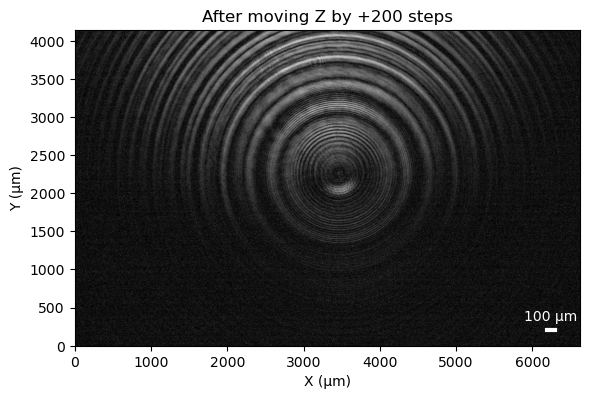

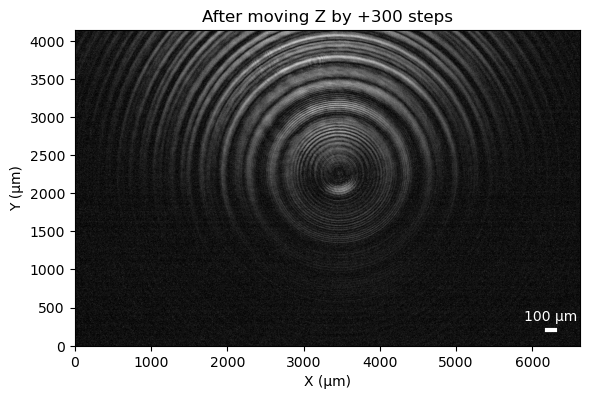

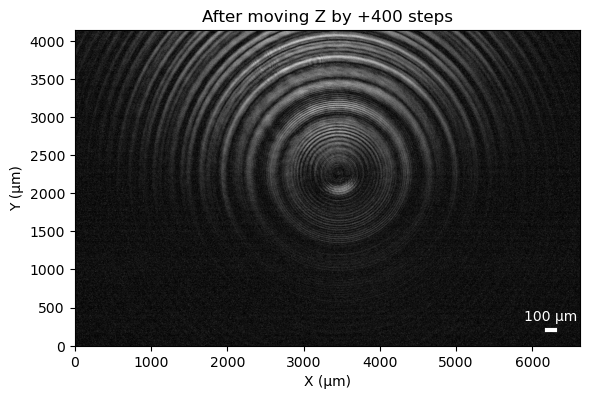

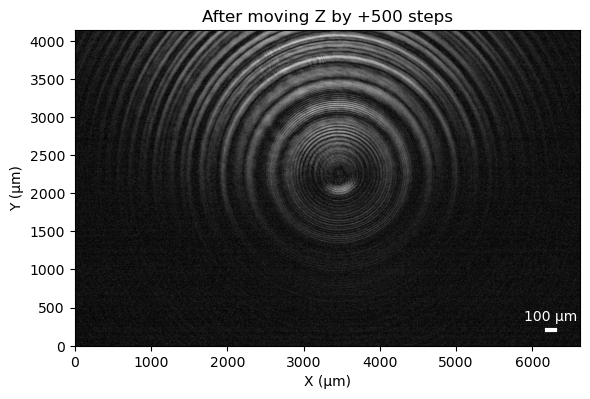

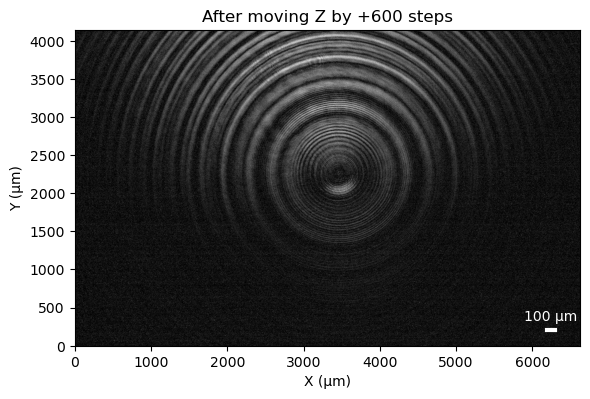

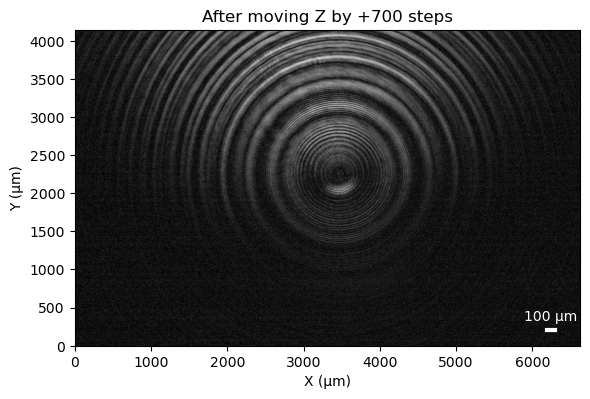

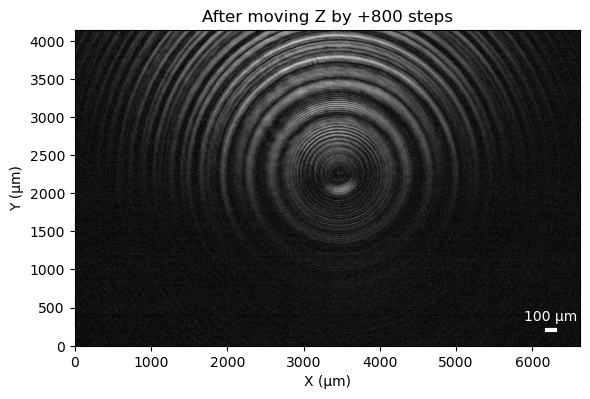

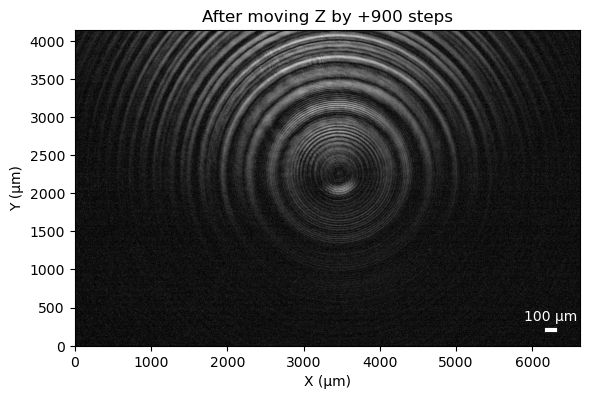

In [258]:
# Call with default parameters (19 µs exposure, 100 µm scalebar)
image, pixel_size_um = acquire_and_plot_image(camera, title='Original position')

motor_z.move_by(100)
for i in range(1, 10):
    image, pixel_size_um = acquire_and_plot_image(camera, title=f'After moving Z by +{i*100} steps')
    motor_z.move_by(100)


In [ ]:
# x and y seem to be flipped, but i don't know how to change it (without changing the labels on the motors)

In [ ]:
# don't know how to relate steps to metric units (pylablib documentation says this is usually impossible?)

changing z-distance

In [229]:
motor_x.close()
motor_y.close()
motor_z.close()

In [ ]:
camera.Close()